In [ ]:
import math, random
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [23]:
# Set random seed to replay
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(20)

In [24]:

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0,1,100)
# print(train_x)
# print(type(train_x))

# True function is sin(2*pi*x) with Gaussian noise \epsilon ~ N(0, 0.04).
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
# print(train_y)
# print(type(train_x))

In [31]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ExactGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    # prior mean and covariance_matrix
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initial model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
loss_tolerence = 1e-5
loss_min = 10.0

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    if loss.item() < loss_min:
        if loss_min - loss.item() <= loss_tolerence:
            print("Loss less change.")
            break
        else:
            loss_min = loss.item()
    optimizer.step()

Iter 1/100 - Loss: 0.928   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.896   lengthscale: 0.644   noise: 0.644
Iter 3/100 - Loss: 0.862   lengthscale: 0.598   noise: 0.598
Iter 4/100 - Loss: 0.825   lengthscale: 0.555   noise: 0.554
Iter 5/100 - Loss: 0.783   lengthscale: 0.514   noise: 0.513
Iter 6/100 - Loss: 0.736   lengthscale: 0.475   noise: 0.474
Iter 7/100 - Loss: 0.687   lengthscale: 0.439   noise: 0.437
Iter 8/100 - Loss: 0.636   lengthscale: 0.404   noise: 0.402
Iter 9/100 - Loss: 0.587   lengthscale: 0.372   noise: 0.370
Iter 10/100 - Loss: 0.542   lengthscale: 0.342   noise: 0.339
Iter 11/100 - Loss: 0.501   lengthscale: 0.315   noise: 0.311
Iter 12/100 - Loss: 0.463   lengthscale: 0.291   noise: 0.284
Iter 13/100 - Loss: 0.428   lengthscale: 0.272   noise: 0.259
Iter 14/100 - Loss: 0.393   lengthscale: 0.255   noise: 0.237
Iter 15/100 - Loss: 0.360   lengthscale: 0.243   noise: 0.216
Iter 16/100 - Loss: 0.326   lengthscale: 0.233   noise: 0.197
Iter 17/100 - Los

In [56]:

test_x = torch.linspace(0, 1, 51)
test_y = torch.sin(test_x * (2 * math.pi)) + torch.randn(test_x.size()) * math.sqrt(0.04)

# f_preds = model(test_x)
# y_preds = likelihood(model(test_x))

# f_mean = f_preds.mean
# f_var = f_preds.variance
# f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

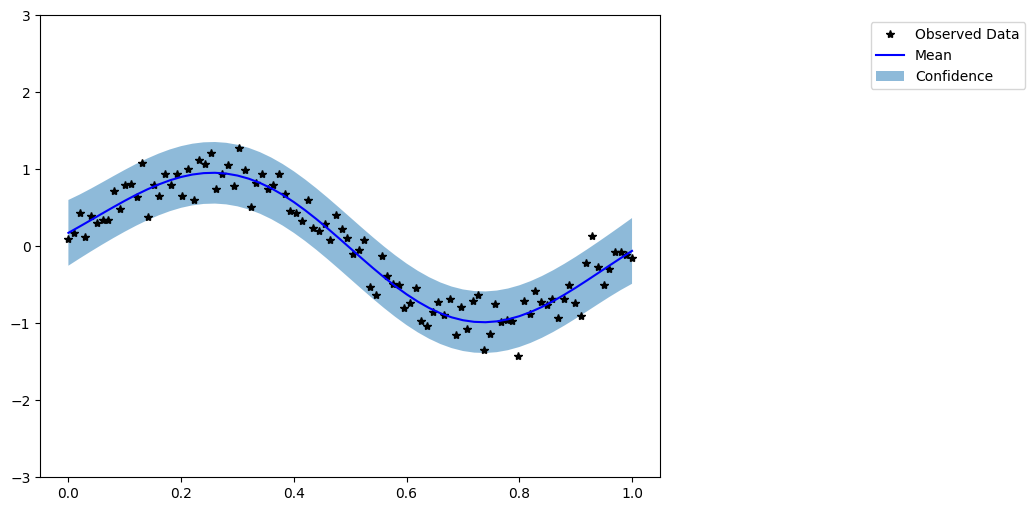

In [65]:
# Go into the evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad():
    trained_pred_dist = likelihood(model(test_x))
    pred_mean = trained_pred_dist.mean
    pred_covar = trained_pred_dist.covariance_matrix
    lower, upper = trained_pred_dist.confidence_region()

f, ax = plt.subplots(1, 1, figsize=(8, 6))
# Plot training data as black stars
ax.plot(train_x, train_y, 'k*')
# Plot predictive means as blue line
ax.plot(test_x, pred_mean, 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x, lower, upper, alpha=0.5)
# uncertainty = 1.96 * np.sqrt(np.diag(pred_covar.detach().numpy()))
# ax.fill_between(test_x, pred_mean-uncertainty, pred_mean+uncertainty, alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'], bbox_to_anchor=(1.6,1));


In [88]:


train_x1 = torch.tensor([3, 1, 4, 5, 9])
train_y1 = torch.cos(train_x1)

likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
model1 = ExactGPModel(train_x1, train_y1, likelihood1)

# Find optimal model hyperparameters
model1.train()
likelihood1.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1)

training_iter = 1000
loss_tolerence = 1e-5
loss_min = 10.0

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model1(train_x1)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y1)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model1.covar_module.base_kernel.lengthscale.item(),
        model1.likelihood.noise.item()
    ))
    if loss.item() < loss_min:
        if loss_min - loss.item() <= loss_tolerence:
            print("Loss less change.")
            break
        else:
            loss_min = loss.item()
    optimizer.step()

Iter 1/1000 - Loss: 1.256   lengthscale: 0.693   noise: 0.693
Iter 2/1000 - Loss: 1.212   lengthscale: 0.744   noise: 0.644
Iter 3/1000 - Loss: 1.175   lengthscale: 0.797   noise: 0.598
Iter 4/1000 - Loss: 1.145   lengthscale: 0.849   noise: 0.554
Iter 5/1000 - Loss: 1.122   lengthscale: 0.897   noise: 0.513
Iter 6/1000 - Loss: 1.105   lengthscale: 0.934   noise: 0.474
Iter 7/1000 - Loss: 1.088   lengthscale: 0.956   noise: 0.438
Iter 8/1000 - Loss: 1.069   lengthscale: 0.961   noise: 0.404
Iter 9/1000 - Loss: 1.049   lengthscale: 0.950   noise: 0.372
Iter 10/1000 - Loss: 1.028   lengthscale: 0.928   noise: 0.343
Iter 11/1000 - Loss: 1.008   lengthscale: 0.898   noise: 0.316
Iter 12/1000 - Loss: 0.993   lengthscale: 0.863   noise: 0.292
Iter 13/1000 - Loss: 0.983   lengthscale: 0.825   noise: 0.269
Iter 14/1000 - Loss: 0.977   lengthscale: 0.786   noise: 0.249
Iter 15/1000 - Loss: 0.973   lengthscale: 0.749   noise: 0.231
Iter 16/1000 - Loss: 0.969   lengthscale: 0.715   noise: 0.215
I

Parameter name: likelihood.noise_covar.raw_noise           value = -3.248281478881836
Parameter name: mean_module.raw_constant                   value = 0.027199234813451767
Parameter name: covar_module.raw_outputscale               value = 0.007263238541781902
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -1.1463831663131714


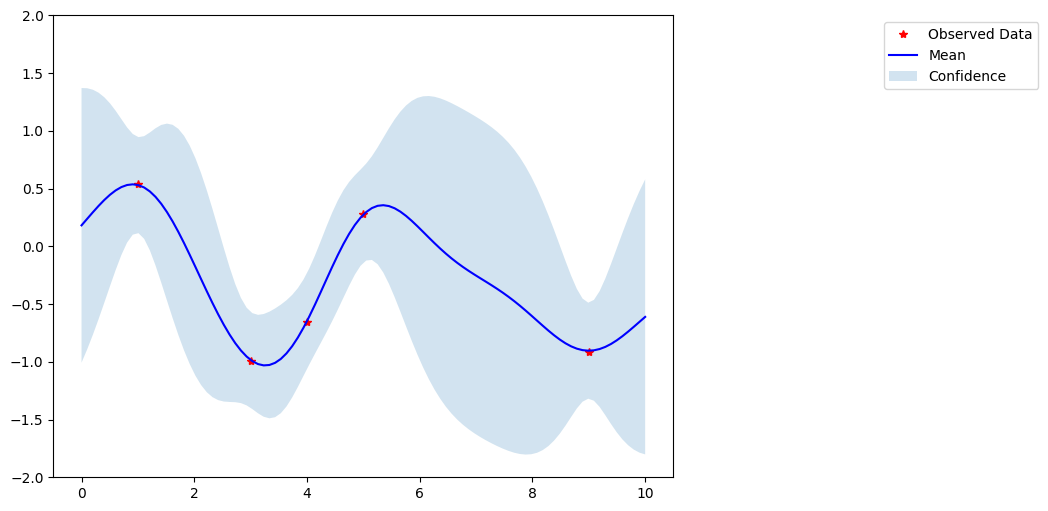

In [89]:
model1.eval()
likelihood1.eval()

with torch.no_grad():
    test_x1 = torch.linspace(0, 10, 100)
    trained_pred_dist = likelihood(model1(test_x1))
    pred_mean = trained_pred_dist.mean
    pred_covar = trained_pred_dist.covariance_matrix
    lower, upper = trained_pred_dist.confidence_region()
    for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.item()}')

f, ax = plt.subplots(1, 1, figsize=(8, 6))
# Plot training data as black stars
ax.plot(train_x1, train_y1, 'r*')
# Plot predictive means as blue line
ax.plot(test_x1, pred_mean, 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x1, lower, upper, alpha=0.2)
# uncertainty = 1.96 * np.sqrt(np.diag(pred_covar.detach().numpy()))
# ax.fill_between(test_x1, pred_mean-uncertainty, pred_mean+uncertainty, alpha=0.5)
ax.set_ylim([-2, 2])
ax.legend(['Observed Data', 'Mean', 'Confidence'], bbox_to_anchor=(1.6,1));